In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from omegaconf import OmegaConf

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import os

In [4]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [5]:
def value_rescale(x, eps=1.0e-3):
    return np.sign(x) * (np.sqrt(np.abs(x) + 1.0) - 1.0) + eps * x

In [34]:
# Good params on cart-pole from proprio
# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_saved_experiments/long_ff_cart/"

# maze



# DIR = "/home/ira/code/projects/rl_trickery/runs/2020.06.18/"

# DIR = "/home/ira/code/projects/rl_trickery/multirun/2020-06-16/20-38-12//"


In [35]:
# maze runs


# maze11
# random recurse depth
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-ff-rand-recurse/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-rnn-rand-recurse/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-crnn-rand-recurse/"



In [46]:
DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/11-26-38_crnn_append_coords/"


In [47]:
runs = sorted(os.listdir(DIR))
runs = [run for run in runs if "." not in run]
runs

['crnn_append_coords_0',
 'crnn_append_coords_1',
 'crnn_append_coords_2',
 'crnn_append_coords_3',
 'crnn_append_coords_4',
 'crnn_append_coords_5',
 'crnn_append_coords_6',
 'crnn_append_coords_7',
 'crnn_append_coords_8',
 'crnn_append_coords_9']

In [48]:
dfs = {}
dfs_eval = {}
overrides = {}
configs = {}
for run in runs:
    f_eval = DIR + run + "/eval.csv"
    f_train = DIR + run + "/train.csv"    
    f_config = DIR + run + "/.hydra/config.yaml"    
    f_override = DIR + run + "/.hydra/overrides.yaml"    
    dfs[run] = pd.read_csv(f_train)
    dfs_eval[run] = pd.read_csv(f_eval)
    try:
        with open(f_override) as file:
            overrides[run] = yaml.load(file, Loader=yaml.FullLoader)
    except FileNotFoundError:
        overrides[run] = {}
    try:
        configs[run] = OmegaConf.load(f_config)
    except FileNotFoundError:
        configs[run] = {}
        

In [49]:
scores = {}
for run in runs:
#     scores[run] = -dfs_eval[run]["fraction_timeouts"][-10:].mean()
    scores[run] = dfs[run]["episode_reward"][0:].mean()
scores = pd.Series(scores)
scores

crnn_append_coords_0    135.257917
crnn_append_coords_1    149.266667
crnn_append_coords_2    140.913125
crnn_append_coords_3    141.537292
crnn_append_coords_4    154.542292
crnn_append_coords_5    113.784613
crnn_append_coords_6    145.529792
crnn_append_coords_7    151.433053
crnn_append_coords_8    131.994375
crnn_append_coords_9    131.907500
dtype: float64

In [50]:
rows = {}
for key, arg in overrides.items():
    row = {}
    if type(arg) is list:
        for s in arg:
            col, val = s.split("=")
            row[col] = val
        rows[key] = (pd.Series(row))
results = pd.DataFrame(rows)
results = results.append(scores.rename("score"))
results = results.T.sort_values("score", ascending=False)

In [51]:
for key, config in configs.items():
    configs[key] = flatten(config)
full_results = pd.DataFrame(configs).append(scores.rename("score")).T.sort_values("score", ascending=False)

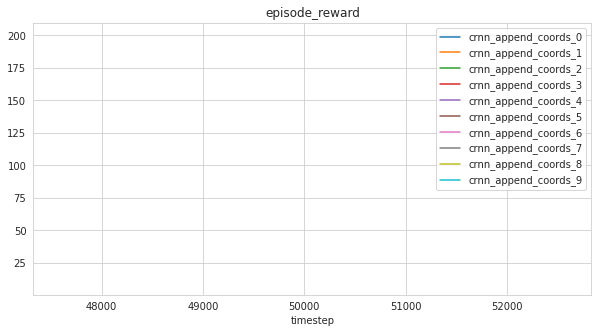

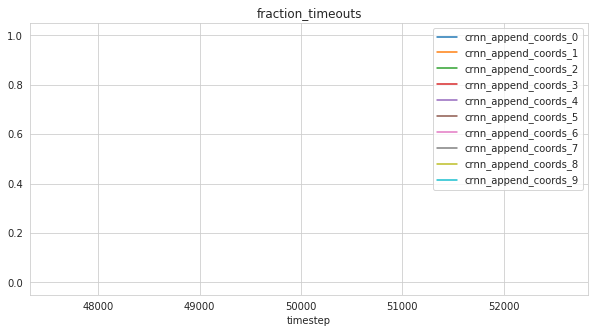

In [52]:
ax = None

target_vars = [
    "episode_reward",
    "fraction_timeouts",
]

top_q = 0.0
y_lim = None

for target_var in target_vars:
    ax = None
    for key, df in dfs_eval.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df.set_index("timestep")[target_var]
#             df = df.rolling(0).mean()
#             df = value_rescale(df)
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5), ylim=y_lim)
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

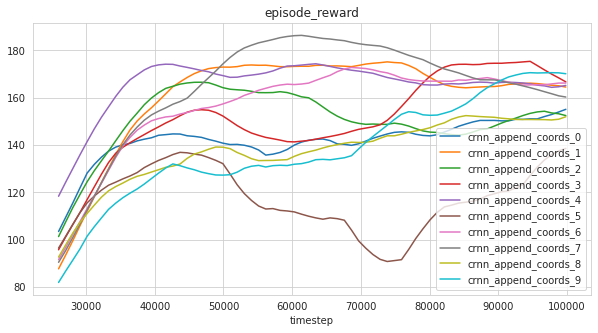

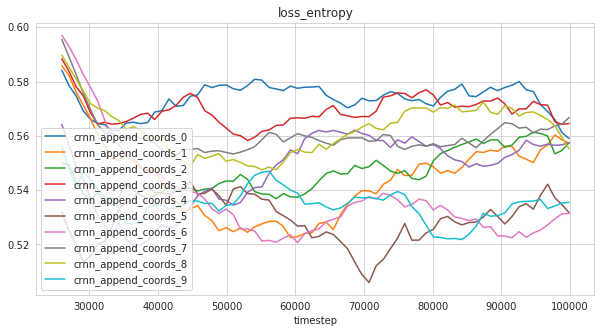

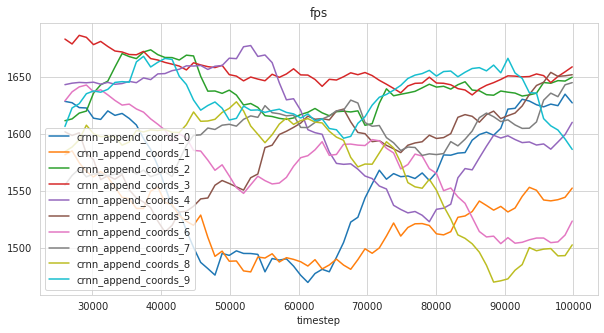

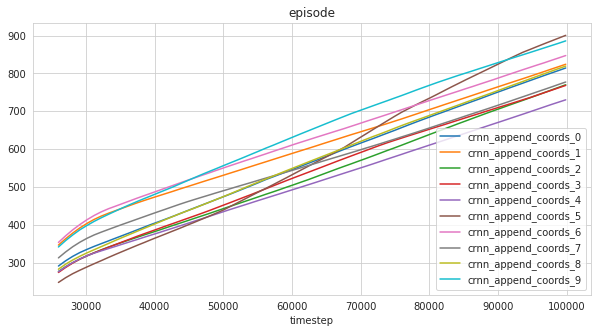

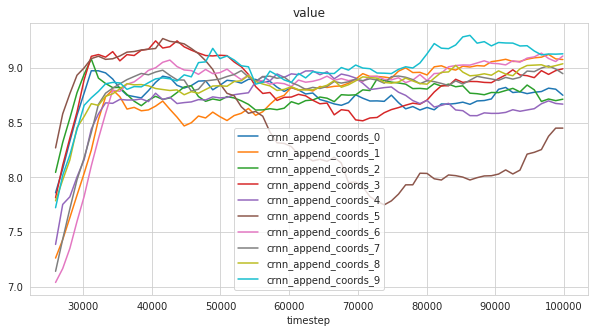

In [53]:
ax = None

target_vars = [
    "episode_reward",
    "loss_entropy",
    "act",
    "fps",
    "episode",
    "value",
]

top_q = 0.0
y_lim = None

for target_var in target_vars:
    ax = None
    for key, df in dfs.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df.set_index("timestep")[target_var]
            df = df.rolling(25).mean()
#             df = value_rescale(df)
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5), ylim=y_lim)
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

In [54]:
results.score = results.score.map(float)

In [55]:
fix_rec = results["agent.network_params.fixed_recursive_depth"].fillna(0).map(float)
rand_rec = (1 / (1 - results["agent.network_params.random_cog_fraction"].fillna("0").map(float))) - 1
results["fix_rec"] = fix_rec
results["rand_rec"] = rand_rec
results["any_recurse"] = fix_rec + rand_rec + 1
results[["any_recurse", "score"]].corr()

KeyError: 'agent.network_params.fixed_recursive_depth'

In [25]:
results[["fix_rec", "score"]].corr()

,fix_rec,score
fix_rec,1.000000,-0.038539
score,-0.038539,1.000000


In [26]:
results[["rand_rec", "score"]].corr()

,rand_rec,score
rand_rec,1.000000,-0.147071
score,-0.147071,1.000000


In [28]:
results

,agent,agent.network_params.append_a_cog,agent.network_params.fixed_recursive_depth,agent.network_params.random_cog_fraction,env,name,num_timesteps,score,fix_rec,rand_rec,any_recurse
cp_crnn_rand_recurse_8,a2c_proprio,true,NaN,0.8,cartpole,cp_crnn_rand_recurse,1e5,154.785684,0.0,4.0,5.0
cp_crnn_fixed_recurse_4,a2c_proprio,true,2,NaN,cartpole,cp_crnn_fixed_recurse,1e5,151.482862,2.0,0.0,3.0
cp_crnn_rand_recurse_4,a2c_proprio,true,NaN,0.5,cartpole,cp_crnn_rand_recurse,1e5,146.463191,0.0,1.0,2.0
cp_crnn_fixed_recurse_8,a2c_proprio,true,5,NaN,cartpole,cp_crnn_fixed_recurse,1e5,146.294184,5.0,0.0,6.0
cp_crnn_rand_recurse_3,a2c_proprio,true,NaN,0.5,cartpole,cp_crnn_rand_recurse,1e5,144.511915,0.0,1.0,2.0
cp_crnn_fixed_recurse_6,a2c_proprio,true,5,NaN,cartpole,cp_crnn_fixed_recurse,1e5,144.297917,5.0,0.0,6.0
cp_crnn_fixed_recurse_1,a2c_proprio,true,1,NaN,cartpole,cp_crnn_fixed_recurse,1e5,143.331918,1.0,0.0,2.0
cp_crnn_fixed_recurse_2,a2c_proprio,true,1,NaN,cartpole,cp_crnn_fixed_recurse,1e5,143.189167,1.0,0.0,2.0
cp_crnn_fixed_recurse_3,a2c_proprio,true,2,NaN,cartpole,cp_crnn_fixed_recurse,1e5,142.586250,2.0,0.0,3.0
cp_crnn_fixed_recurse_5,a2c_proprio,true,2,NaN,cartpole,cp_crnn_fixed_recurse,1e5,141.685625,2.0,0.0,3.0
